In [1]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from random import random

In [2]:
class Params:
    def __init__(self):
        self.grid_resolution = 0.5
        self.threshold = 5
        self.maxiters = 100
        self.smoothiters = 150

In [3]:
class Robot:
    def __init__(self):
        self.p = [0, 0]
        self.ballradius = 0.5

In [4]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.iPrev = 0

In [5]:
# Helper functions
from matplotlib import path

def isCollisionFreeVertex(robot, obstacles):
    # the function calculates value:
    # collFree = [xy-point is outside obstacles map]
    collFree = 1
    xy = robot.p
    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print "collision Vertex"
            return 0

    return collFree

In [6]:
def isCollisionFreeEdge(robot, obstacles, p1, p2, map_resolution=0.5):
    p1 = np.array(p1); p2 = np.array(p2)
    collFree = 1
    l = norm(p1 - p2)
    M = int(l / map_resolution)
    if M <= 2: M = 3
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*p1 + t[i]*p2 # calculate configuration
        robot.p = p
        collFree = isCollisionFreeVertex(robot, obstacles) 
        if collFree == 0:
#             print "collision Edge"
            return 0

    return collFree

In [7]:
r = Robot()
r.p = [0.5, 1.0]
w = 0.2
obstacles = [
              np.array([[0, 0], [1, 0], [1, 0.1], [0, w]]),
              np.array([[0, 0], [w, 0.2], [0.1, 2], [0.0, 2.0]]),
              np.array([[0, 2-w], [1, 2], [1, 2+w], [0, 2+w]]),
              np.array([[1-w, 0], [1+w, 0], [1+w, 1], [1, 1]]),
              np.array([[1-w, 2+w], [1+w, 2+w], [1+w, 1.5], [1, 1.5]]),
              np.array([[0.8, 1], [1+w, 1], [1+w, 1+w], [0.8, 1+w]]),
              np.array([[0.8, 1.5], [1+w, 1.5], [1+w, 1.5+w], [0.8, 1.5+w]])
]  
isCollisionFreeVertex(r, obstacles)

True

In [8]:
def AddNode(rrt, node, iPrev):
#     print(node.p)
    node.iPrev = iPrev
    rrt.append( node )
    return rrt

In [39]:
def PlanPathRRT(robot, obstacles, param, p_start, p_goal):
    P = []
    node = Node()
    node.p = p_start
    rrt = []
#     rrt = AddNode(rrt, node, 0)
    k = 0
    while k <= 5:
        p = np.random.rand(2)

        node.p = p
#         print node.p
        rrt.append(node)
        print rrt[0].p
        k = k + 1
    
    return rrt

In [ ]:
rrt = PlanPathRRT(Robot(), [], )

[0.35783592 0.44312651]
[0.61439477 0.25994732]
[0.21552309 0.22816228]
[0.64247324 0.54725753]
[0.58453057 0.55920295]
[0.12391514 0.66810168]


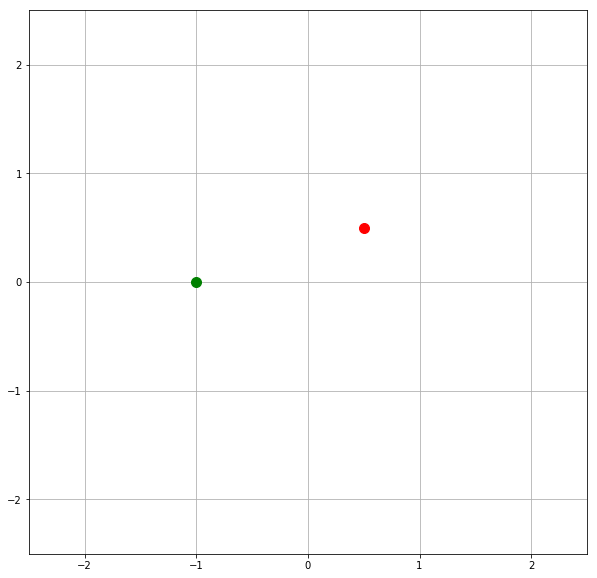

In [38]:
# Obstacle Locations
w = 0.2
obstacles = [
              np.array([[0, 0], [1, 0], [1, 0.1], [0, w]]),
              np.array([[0, 0], [w, 0.2], [0.1, 2], [0.0, 2.0]]),
              np.array([[0, 2-w], [1, 2], [1, 2+w], [0, 2+w]]),
              np.array([[1-w, 0], [1+w, 0], [1+w, 1], [1, 1]]),
              np.array([[1-w, 2+w], [1+w, 2+w], [1+w, 1.5], [1, 1.5]]),
              np.array([[0.8, 1], [1+w, 1], [1+w, 1+w], [0.8, 1+w]]),
              np.array([[0.8, 1.5], [1+w, 1.5], [1+w, 1.5+w], [0.8, 1.5+w]])
            ]
obstacles = []


# Set Start and Goal locations
p_start = [0.5, 0.5]
p_goal = [-1, 0]
fig = plt.figure(figsize=(10, 10))
plt.plot(p_start[0], p_start[1], 'ro', markersize=10)
plt.plot(p_goal[0], p_goal[1], 'ro', markersize=10, color='green')


# initialization
robot = Robot()
robot.ballradius = 0.5
robot.p = p_start

param = Params()


from matplotlib.patches import Polygon

# Bounds on world
world_bounds_x = [-2.5, 2.5]
world_bounds_y = [-2.5, 2.5]


# Draw obstacles
plt.grid()
ax = plt.gca()
ax.set_xlim(world_bounds_x)
ax.set_ylim(world_bounds_y)
for k in range(len(obstacles)):
    ax.add_patch( Polygon(obstacles[k]) )
    
# Plan the path
rrt = PlanPathRRT(robot, obstacles, param, p_start, p_goal)

# for i in range(len(rrt)):
#     plt.plot(rrt[i].p[0], rrt[i].p[1], 'ro')
#     print(rrt[i].p)

# Plot the path from RRT
# for i in range(1, len(P)):
#     plt.plot([P(1,i);P(1,i-1)],[P(2,i);P(2,i-1)],'r','LineWidth',3)